In [1]:
import __init__
from src.utilities import train_test_validation_splits, \
                            prepare_train_test_val_seqs_by_batches, \
                            tensor2dataloader, load_full_meltome_FLIP_db, \
                            seek_UniprotID_association_Meltome_prots,\
                            download_UniprotID_Alphafold_Structures
import pandas as pd
import numpy as np
    
path_meltome = '../datasets/FLIP/splits/meltome/splits/mixed_split.csv'
complete_meltome_db = '../datasets/FLIP/splits/meltome/full_dataset_sequences.fasta'

full_meltome_db = load_full_meltome_FLIP_db(complete_meltome_db)

splits_meltome = pd.read_csv(path_meltome, sep=',')
split_meltome = splits_meltome[splits_meltome['sequence'].str.len()>= 50]
train, val, test = train_test_validation_splits(splits_meltome)
train = seek_UniprotID_association_Meltome_prots(train, full_meltome_db)
test = seek_UniprotID_association_Meltome_prots(test, full_meltome_db)
val = seek_UniprotID_association_Meltome_prots(val, full_meltome_db)
#print(train)
print("Done")



#ff=full_meltome_db[full_meltome_db['sequence'].isin(train['sequence'])]

Done


In [2]:
from tqdm.auto import tqdm
import torch
from src.ESM2embeddings import ESM2embeddings
from src.utilities import train_test_validation_splits, prepare_train_test_val_seqs_by_batches, tensor2dataloader
from src.NeuralArchitectures import regressionHead
from src.Trainer import Trainer

structuredir = '../datasets/Structures/'
meltome_struct_dir_labels = '../datasets/'


import os 
if not os.listdir(structuredir) and not os.path.isfile(meltome_struct_dir_labels+'Meltome_Splits_FLIPS_train.txt')\
                                and not os.path.isfile(meltome_struct_dir_labels+'Meltome_Splits_FLIPS_test.txt')\
                                and not os.path.isfile(meltome_struct_dir_labels+'Meltome_Splits_FLIPS_val.txt'): 
    
    print("Finding structures to proteins via Alphafold/PDB dbs..........") 
    
    download_UniprotID_Alphafold_Structures(train, structuredir, meltome_struct_dir_labels, 'Meltome_Splits_FLIPS_train')
    download_UniprotID_Alphafold_Structures(test, structuredir, meltome_struct_dir_labels, 'Meltome_Splits_FLIPS_test')
    download_UniprotID_Alphafold_Structures(val, structuredir, meltome_struct_dir_labels, 'Meltome_Splits_FLIPS_val')



Structinfo_Meltome_Splits_train = pd.read_csv( meltome_struct_dir_labels+'Meltome_Splits_FLIPS_train.txt', sep='\t')
Structinfo_Meltome_Splits_test = pd.read_csv( meltome_struct_dir_labels+'Meltome_Splits_FLIPS_test.txt', sep='\t')
Structinfo_Meltome_Splits_val = pd.read_csv( meltome_struct_dir_labels+'Meltome_Splits_FLIPS_val.txt', sep='\t')


train = pd.concat([train, Structinfo_Meltome_Splits_train], axis=1).query('Source=="alphafold"')
test = pd.concat([test, Structinfo_Meltome_Splits_test], axis=1).query('Source=="alphafold"')
val = pd.concat([val, Structinfo_Meltome_Splits_val], axis=1).query('Source=="alphafold"')



In [3]:

import torch
import torch_geometric
import torch_sparse
from torch_geometric.nn import MessagePassing

import esm
model, alphabet = esm.pretrained.esm_if1_gvp4_t16_142M_UR50()
model = model.eval()

pt_batch_size = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ESM2 = ESM2embeddings(type_embedding = "facebook/esm2_t33_650M_UR50D", device = device, type_tool='FacebookESM2')

dir_pre_generated_embeddings = '../prepro_embeddings/'

path_train= dir_pre_generated_embeddings+'train_set_embeddings_ESM2_with_StructAssociation.pth'
path_test= dir_pre_generated_embeddings+'test_set_embeddings_ESM2_with_StructAssociation.pth'
path_val= dir_pre_generated_embeddings+'val_set_embeddings_ESM2_with_StructAssociation.pth'

path_IFtrain= dir_pre_generated_embeddings+'train_set_IFembeddings_ESM2_StructAssociation.pth'
path_IFtest= dir_pre_generated_embeddings+'test_set_IFembeddings_ESM2_StructAssociation.pth'
path_IFval= dir_pre_generated_embeddings+'val_set_IFembeddings_ESM2_StructAssociation.pth'




def embedding_builder_ESM2(ESM2, device, train, test, val, path_train, path_test, path_val):
    if os.path.isfile(path_train)==False and os.path.isfile(path_test)==False and os.path.isfile(path_val)==False:

        """batch_train, batch_test, batch_val = prepare_train_test_val_seqs_by_batches(train.sequence.to_list(), 
                                                                                    test.sequence.to_list(), 
                                                                                    val.sequence.to_list(), 
                                                                                    batch_size=2)"""
        print ("Creating Embeddings...")   
        train_embeddings = ESM2.esm2embedding(train, device, layer_index=33) #esm2embedding(train, model, batch_converter, device, layer_index=33)#BERT.embed_dataset(batch_train)
        torch.save(train_embeddings, path_train)
        test_embeddings = ESM2.esm2embedding(test, device, layer_index=33) #esm2embedding(test, model, batch_converter, device, layer_index=33)
        torch.save(test_embeddings, path_test)
        val_embeddings = ESM2.esm2embedding(val, device, layer_index=33) #esm2embedding(val, model, batch_converter, device, layer_index=33)
        torch.save(val_embeddings, path_val)
        print ("Loaded")
    else:
        print ("Loading Premade Embeddings...")
        train_embeddings = torch.load(path_train)
        test_embeddings = torch.load(path_test)
        val_embeddings = torch.load(path_val)
        print ("Loaded")
    return train_embeddings, test_embeddings, val_embeddings


def ESM2_IF_repr(df, model, alphabet):
    embeddings = torch.zeros(len(df),512)#torch.tensor([])
    import os
    import gc
    #if not os.path.isdir(dir_pre_generated_embeddings+'IFembeddings/'):
    #    os.mkdir(dir_pre_generated_embeddings+'IFembeddings/')

    with torch.no_grad():
        for i in tqdm(range(0,len(df))):
            fpath = train.iloc[i].Structure_Alphafold
            structure = esm.inverse_folding.util.load_structure(fpath)
            coords, native_seq = esm.inverse_folding.util.extract_coords_from_structure(structure)

            rep = esm.inverse_folding.util.get_encoder_output(model, alphabet, coords)
            rep = rep.mean(0).reshape(1,-1)
            embeddings[i]=rep
            #embeddings = torch.cat([embeddings, rep])
            #torch.save(rep, dir_pre_generated_embeddings+'IFembeddings/'+str(i)+'.pt' )
            #del rep, structure, coords
            #gc.collect()
            #torch.cuda.empty_cache()
    return embeddings



def IFBuilder_sets(model, alphabet, train, test, val, path_IFtrain, path_IFtest, path_IFval):
    if os.path.isfile(path_IFtrain)==False and os.path.isfile(path_IFtest)==False and os.path.isfile(path_IFval)==False:
        import warnings
        warnings.filterwarnings('ignore')

        IF_embeddings_train = ESM2_IF_repr(train, model, alphabet)
        torch.save(IF_embeddings_train, path_IFtrain)

        IF_embeddings_test = ESM2_IF_repr(test, model, alphabet)
        torch.save(IF_embeddings_test, path_IFtest)

        IF_embeddings_val = ESM2_IF_repr(val, model, alphabet)
        torch.save(IF_embeddings_val, path_IFval)
    else:
        print ("Loading Premade Embeddings...")
        train_embeddings = torch.load(path_IFtrain)
        test_embeddings = torch.load(path_IFtest)
        val_embeddings = torch.load(path_IFval)
        print ("Loaded")
    return train_embeddings, test_embeddings, val_embeddings



/z/home/sgal/miniconda3/envs/thermoPML/lib/python3.9/site-packages/esm/pretrained.py:215: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


In [4]:
train_IF_embedding, test_IF_embedding, val_IF_embedding = IFBuilder_sets(model, alphabet, train, test, val, path_IFtrain, path_IFtest, path_IFval)
train_embeddings, test_embeddings, val_embeddings = embedding_builder_ESM2(ESM2, device, train, test, val,  path_train, path_test, path_val)

train_loaderESM2 = tensor2dataloader(train_embeddings, torch.from_numpy( train.target.to_numpy().astype(float) ), batch_size=50)
test_loaderESM2 = tensor2dataloader(test_embeddings, torch.from_numpy( test.target.to_numpy().astype(float) ), batch_size=50)
val_loaderESM2 = tensor2dataloader(val_embeddings, torch.from_numpy( val.target.to_numpy().astype(float) ), batch_size=50)

train_loaderIF = tensor2dataloader(train_IF_embedding, torch.from_numpy( train.target.to_numpy().astype(float) ), batch_size=50)
test_loaderIF = tensor2dataloader(test_IF_embedding, torch.from_numpy( test.target.to_numpy().astype(float) ), batch_size=50)
val_loaderIF = tensor2dataloader(val_IF_embedding, torch.from_numpy( val.target.to_numpy().astype(float) ), batch_size=50)

train_loaderMixed = tensor2dataloader(torch.concat([train_embeddings.to(device), train_IF_embedding.to(device)],dim=1), torch.from_numpy( train.target.to_numpy().astype(float) ), batch_size=50)
test_loaderMixed = tensor2dataloader(torch.concat([test_embeddings.to(device), test_IF_embedding.to(device)],dim=1), torch.from_numpy( test.target.to_numpy().astype(float) ), batch_size=50)
val_loaderMixed = tensor2dataloader(torch.concat([val_embeddings.to(device), val_IF_embedding.to(device)],dim=1), torch.from_numpy( val.target.to_numpy().astype(float) ), batch_size=50)

Loading Premade Embeddings...
Loaded
Loading Premade Embeddings...
Loaded


In [5]:
def generating_results_approaches(FFNNreg, Trner, train_loader, val_loader, test_loader,loss, opt, epochs, device):
    FFNNreg, val_loss = Trner.train_LLMRegresor(train_loader, val_loader, FFNNreg, device, loss, opt, epochs)

    test_set, test_labels = test_loader.dataset.tensors
    loss_test, outcome = Trner.test_model(FFNNreg, test_set, test_labels, loss, device)

    from src.utilities import plot_results

    plot_results( outcome, test_labels)

### For RAW ESM2

epoch: 1 loss: 1142.115 val loss: 1181.819


epoch: 2 loss: 366.286 val loss: 551.553


epoch: 3 loss: 8.736 val loss: 257.954


epoch: 4 loss: 1134.860 val loss: 149.079


epoch: 5 loss: 105.422 val loss: 119.567


epoch: 6 loss: 70.976 val loss: 114.347


epoch: 7 loss: 5.134 val loss: 113.658


epoch: 8 loss: 181.437 val loss: 114.078


epoch: 9 loss: 45.672 val loss: 113.637


epoch: 10 loss: 19.081 val loss: 114.133


epoch: 11 loss: 181.753 val loss: 113.350


epoch: 12 loss: 5.348 val loss: 102.581


epoch: 13 loss: 366.004 val loss: 74.835


epoch: 14 loss: 2.161 val loss: 60.290


epoch: 15 loss: 9.820 val loss: 52.635


epoch: 16 loss: 41.640 val loss: 47.751


epoch: 17 loss: 11.477 val loss: 44.665


epoch: 18 loss: 0.119 val loss: 43.532


epoch: 19 loss: 0.133 val loss: 42.184


epoch: 20 loss: 254.802 val loss: 41.199


epoch: 21 loss: 18.220 val loss: 41.036


epoch: 22 loss: 0.006 val loss: 40.739


epoch: 23 loss: 221.529 val loss: 40.757


epoch: 24 loss: 50.696 val loss: 40.141


epoch: 25 loss: 5.471 val loss: 40.008


epoch: 26 loss: 1.737 val loss: 40.263


epoch: 27 loss: 1.994 val loss: 39.712


epoch: 28 loss: 11.217 val loss: 39.788


epoch: 29 loss: 36.085 val loss: 40.851


epoch: 30 loss: 0.489 val loss: 39.009


epoch: 31 loss: 1.412 val loss: 39.071


epoch: 32 loss: 15.539 val loss: 38.835


epoch: 33 loss: 2.961 val loss: 38.728


epoch: 34 loss: 1.830 val loss: 38.799


epoch: 35 loss: 0.881 val loss: 38.477


epoch: 36 loss: 0.229 val loss: 38.233


epoch: 37 loss: 29.200 val loss: 38.481


epoch: 38 loss: 1.012 val loss: 37.997


epoch: 39 loss: 20.486 val loss: 37.953


epoch: 40 loss: 0.776 val loss: 38.886


epoch: 41 loss: 24.313 val loss: 38.620


epoch: 42 loss: 5.568 val loss: 37.656


epoch: 43 loss: 11.947 val loss: 37.636


epoch: 44 loss: 10.495 val loss: 37.574


epoch: 45 loss: 0.375 val loss: 37.331


epoch: 46 loss: 62.789 val loss: 37.638


epoch: 47 loss: 29.335 val loss: 37.617


epoch: 48 loss: 139.818 val loss: 37.282


epoch: 49 loss: 5.282 val loss: 38.016


epoch: 50 loss: 1.652 val loss: 37.136


epoch: 51 loss: 5.993 val loss: 37.058


epoch: 52 loss: 16.521 val loss: 37.303


epoch: 53 loss: 0.041 val loss: 37.238


epoch: 54 loss: 1.065 val loss: 36.958


epoch: 55 loss: 1.660 val loss: 36.991


epoch: 56 loss: 2.951 val loss: 37.197


epoch: 57 loss: 16.829 val loss: 36.740


epoch: 58 loss: 16.796 val loss: 37.160


epoch: 59 loss: 1.220 val loss: 36.846


epoch: 60 loss: 50.393 val loss: 37.855


epoch: 61 loss: 1.125 val loss: 36.959


epoch: 62 loss: 33.204 val loss: 36.997


epoch: 63 loss: 7.608 val loss: 37.093


epoch: 64 loss: 0.257 val loss: 37.409


epoch: 65 loss: 0.010 val loss: 36.758


epoch: 66 loss: 46.732 val loss: 36.915


epoch: 67 loss: 0.278 val loss: 36.556


epoch: 68 loss: 32.052 val loss: 36.868


epoch: 69 loss: 4.602 val loss: 37.180


epoch: 70 loss: 39.621 val loss: 36.630


epoch: 71 loss: 1.688 val loss: 36.571


epoch: 72 loss: 3.433 val loss: 36.530


epoch: 73 loss: 26.445 val loss: 36.488


epoch: 74 loss: 73.028 val loss: 36.481


epoch: 75 loss: 76.207 val loss: 36.995


epoch: 76 loss: 22.252 val loss: 36.577


epoch: 77 loss: 3.134 val loss: 36.497


epoch: 78 loss: 124.013 val loss: 36.482


epoch: 79 loss: 17.124 val loss: 36.532


epoch: 80 loss: 6.054 val loss: 36.458


epoch: 81 loss: 29.827 val loss: 36.482


epoch: 82 loss: 35.249 val loss: 36.418


epoch: 83 loss: 39.679 val loss: 36.376


epoch: 84 loss: 1.651 val loss: 36.740


epoch: 85 loss: 20.594 val loss: 36.480


epoch: 86 loss: 39.408 val loss: 36.410


epoch: 87 loss: 12.536 val loss: 36.349


epoch: 88 loss: 8.323 val loss: 36.390


epoch: 89 loss: 3.789 val loss: 36.616


epoch: 90 loss: 16.804 val loss: 36.252


epoch: 91 loss: 31.830 val loss: 36.667


epoch: 92 loss: 9.641 val loss: 36.747


epoch: 93 loss: 12.054 val loss: 36.861


epoch: 94 loss: 68.419 val loss: 36.259


epoch: 95 loss: 1.925 val loss: 36.405


epoch: 96 loss: 6.533 val loss: 36.277


epoch: 97 loss: 6.286 val loss: 36.617


epoch: 98 loss: 1.293 val loss: 36.248


epoch: 99 loss: 3.535 val loss: 36.499


epoch: 100 loss: 90.073 val loss: 36.333


epoch: 101 loss: 30.994 val loss: 36.938


epoch: 102 loss: 0.714 val loss: 36.436


epoch: 103 loss: 45.545 val loss: 36.157


epoch: 104 loss: 5.011 val loss: 36.290


epoch: 105 loss: 102.382 val loss: 37.090


epoch: 106 loss: 115.326 val loss: 36.155


epoch: 107 loss: 6.098 val loss: 36.908


epoch: 108 loss: 4.339 val loss: 36.319


epoch: 109 loss: 4.674 val loss: 36.466


epoch: 110 loss: 0.728 val loss: 36.497


epoch: 111 loss: 20.384 val loss: 36.328


epoch: 112 loss: 3.283 val loss: 36.682


epoch: 113 loss: 10.525 val loss: 36.312


epoch: 114 loss: 1.811 val loss: 36.357


epoch: 115 loss: 0.441 val loss: 36.358


epoch: 116 loss: 0.263 val loss: 36.375


epoch: 117 loss: 2.113 val loss: 36.279


epoch: 118 loss: 100.871 val loss: 36.203


epoch: 119 loss: 0.597 val loss: 36.865


epoch: 120 loss: 0.009 val loss: 36.190


epoch: 121 loss: 17.622 val loss: 36.249


epoch: 122 loss: 1.827 val loss: 36.227


epoch: 123 loss: 2.706 val loss: 36.488


epoch: 124 loss: 10.305 val loss: 36.272


epoch: 125 loss: 215.928 val loss: 37.088


epoch: 126 loss: 2.377 val loss: 36.140


epoch: 127 loss: 16.296 val loss: 35.979


epoch: 128 loss: 5.489 val loss: 36.529


epoch: 129 loss: 1.252 val loss: 36.957


epoch: 130 loss: 18.634 val loss: 39.366


epoch: 131 loss: 0.383 val loss: 36.827


epoch: 132 loss: 97.676 val loss: 36.213


epoch: 133 loss: 55.473 val loss: 36.216


epoch: 134 loss: 48.807 val loss: 36.175


epoch: 135 loss: 71.342 val loss: 37.015


epoch: 136 loss: 12.244 val loss: 36.027


epoch: 137 loss: 8.239 val loss: 36.072


epoch: 138 loss: 10.685 val loss: 36.142


epoch: 139 loss: 57.304 val loss: 36.979


epoch: 140 loss: 0.944 val loss: 36.187


epoch: 141 loss: 9.728 val loss: 36.117


epoch: 142 loss: 5.552 val loss: 36.490


epoch: 143 loss: 1.082 val loss: 36.047


epoch: 144 loss: 14.226 val loss: 36.786


epoch: 145 loss: 10.262 val loss: 36.425


epoch: 146 loss: 27.879 val loss: 36.295


epoch: 147 loss: 58.505 val loss: 37.073


epoch: 148 loss: 0.002 val loss: 37.132


epoch: 149 loss: 5.625 val loss: 37.118


epoch: 150 loss: 11.751 val loss: 36.195


epoch: 151 loss: 8.006 val loss: 36.159


epoch: 152 loss: 14.690 val loss: 36.309


epoch: 153 loss: 0.005 val loss: 36.782


epoch: 154 loss: 15.630 val loss: 36.189


epoch: 155 loss: 13.329 val loss: 36.117


epoch: 156 loss: 15.195 val loss: 36.105


epoch: 157 loss: 5.355 val loss: 36.186


epoch: 158 loss: 19.776 val loss: 36.067


epoch: 159 loss: 24.905 val loss: 35.927


epoch: 160 loss: 83.637 val loss: 36.060


epoch: 161 loss: 0.438 val loss: 35.924


epoch: 162 loss: 63.382 val loss: 36.120


epoch: 163 loss: 33.034 val loss: 36.124


epoch: 164 loss: 20.804 val loss: 35.975


epoch: 165 loss: 2.152 val loss: 36.365


epoch: 166 loss: 0.209 val loss: 36.002


epoch: 167 loss: 3.162 val loss: 35.883


epoch: 168 loss: 2.307 val loss: 36.062


epoch: 169 loss: 93.504 val loss: 37.174


epoch: 170 loss: 8.775 val loss: 36.148


epoch: 171 loss: 124.595 val loss: 36.365


epoch: 172 loss: 0.420 val loss: 36.003


epoch: 173 loss: 11.535 val loss: 36.766


epoch: 174 loss: 1.129 val loss: 36.369


epoch: 175 loss: 23.083 val loss: 36.269


epoch: 176 loss: 15.042 val loss: 36.040


epoch: 177 loss: 7.178 val loss: 36.218


epoch: 178 loss: 0.476 val loss: 35.903


epoch: 179 loss: 136.423 val loss: 36.544


epoch: 180 loss: 247.945 val loss: 38.198


epoch: 181 loss: 82.646 val loss: 36.002


epoch: 182 loss: 123.332 val loss: 36.465


epoch: 183 loss: 67.402 val loss: 36.451


epoch: 184 loss: 41.700 val loss: 36.416


epoch: 185 loss: 80.024 val loss: 36.514


epoch: 186 loss: 0.119 val loss: 35.896


epoch: 187 loss: 11.336 val loss: 36.275


epoch: 188 loss: 0.012 val loss: 36.619


epoch: 189 loss: 9.141 val loss: 36.050


epoch: 190 loss: 2.790 val loss: 35.952


epoch: 191 loss: 1.142 val loss: 36.094


epoch: 192 loss: 14.994 val loss: 36.259


epoch: 193 loss: 20.553 val loss: 35.936


epoch: 194 loss: 71.714 val loss: 36.131


epoch: 195 loss: 4.590 val loss: 36.151


epoch: 196 loss: 29.500 val loss: 36.802


epoch: 197 loss: 3.742 val loss: 35.982


epoch: 198 loss: 5.547 val loss: 36.731


epoch: 199 loss: 0.583 val loss: 36.479


epoch: 200 loss: 0.822 val loss: 36.423
MSE: tensor(38.8036, device='cuda:0', grad_fn=<MseLossBackward0>)
RMSE: tensor(6.2293, device='cuda:0', grad_fn=<SqrtBackward0>)
MAE: tensor(4.5259, device='cuda:0', grad_fn=<MeanBackward0>)


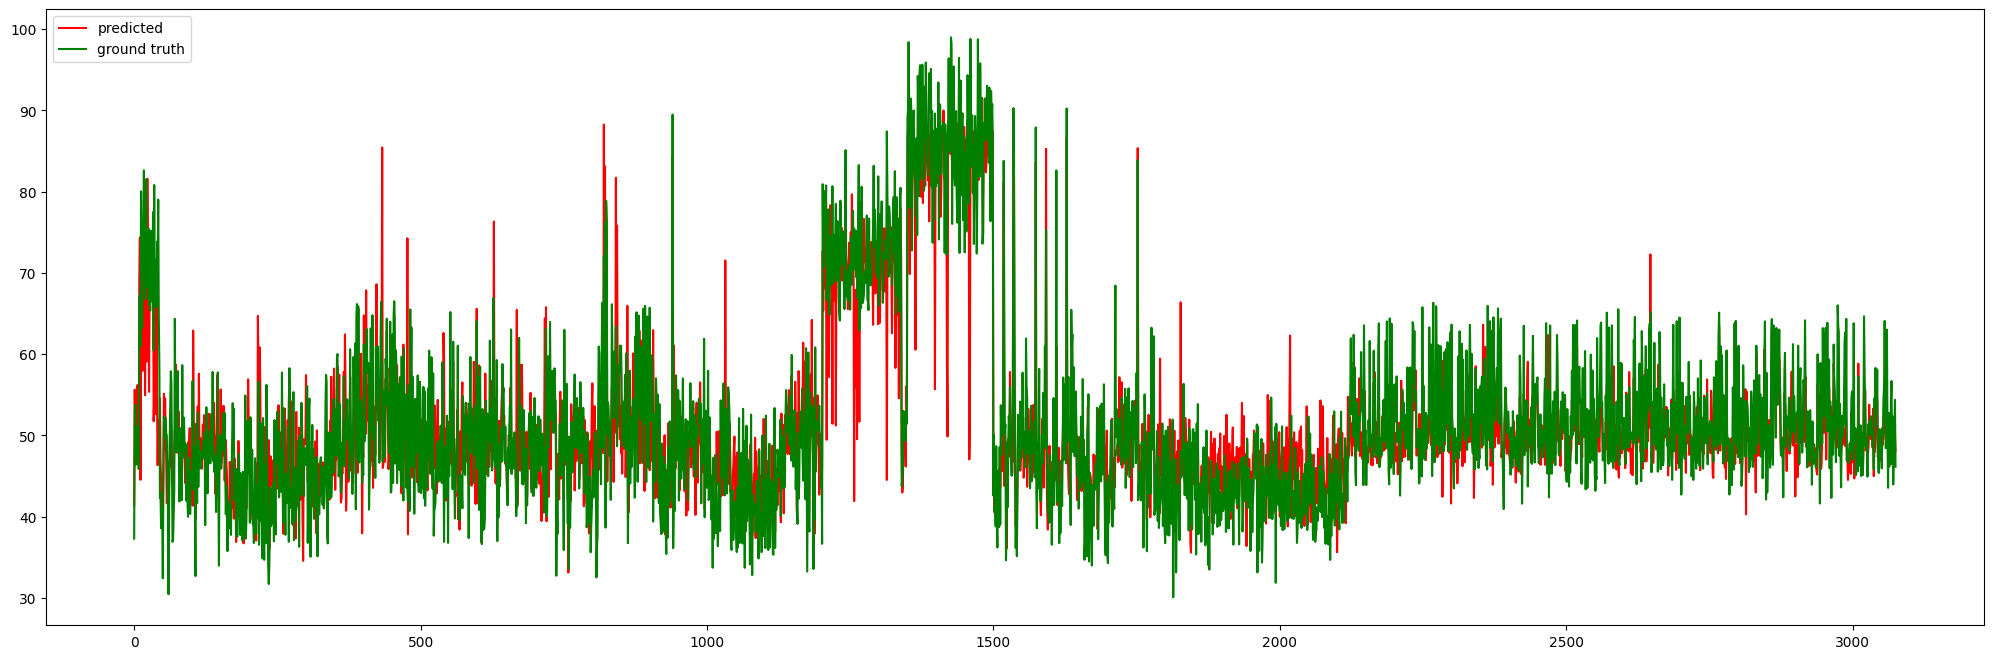

In [6]:
Trainer1 = Trainer()
FFNN_ESM2 = regressionHead(train_embeddings.shape[1::])
optESM2 = torch.optim.Adam(FFNN_ESM2.parameters(), lr=1e-4)
lossESM2= torch.nn.MSELoss()
epochs = 200

generating_results_approaches(FFNN_ESM2, Trainer1, train_loaderESM2, val_loaderESM2, test_loaderESM2,lossESM2, optESM2, epochs, device)

### For Inverse Folding ESM2 Contribution

epoch: 1 loss: 724.687 val loss: 1167.803


epoch: 2 loss: 1337.371 val loss: 536.459


epoch: 3 loss: 0.568 val loss: 247.978


epoch: 4 loss: 183.383 val loss: 143.554


epoch: 5 loss: 4.476 val loss: 118.429


epoch: 6 loss: 214.478 val loss: 114.019


epoch: 7 loss: 58.165 val loss: 113.795


epoch: 8 loss: 20.193 val loss: 113.582


epoch: 9 loss: 22.783 val loss: 114.191


epoch: 10 loss: 383.135 val loss: 113.559


epoch: 11 loss: 58.234 val loss: 113.651


epoch: 12 loss: 3.637 val loss: 113.728


epoch: 13 loss: 13.352 val loss: 113.712


epoch: 14 loss: 16.178 val loss: 113.593


epoch: 15 loss: 15.608 val loss: 113.876


epoch: 16 loss: 116.182 val loss: 113.777


epoch: 17 loss: 198.674 val loss: 113.976


epoch: 18 loss: 0.099 val loss: 113.819


epoch: 19 loss: 1724.704 val loss: 118.821


epoch: 20 loss: 9.133 val loss: 124.878


epoch: 21 loss: 36.711 val loss: 126.149


epoch: 22 loss: 40.251 val loss: 129.488


epoch: 23 loss: 31.100 val loss: 130.856


epoch: 24 loss: 1.789 val loss: 133.249


epoch: 25 loss: 0.448 val loss: 135.282


epoch: 26 loss: 3.797 val loss: 137.070


epoch: 27 loss: 10.834 val loss: 135.082


epoch: 28 loss: 13.410 val loss: 138.029


epoch: 29 loss: 5.944 val loss: 142.701


epoch: 30 loss: 70.069 val loss: 142.437


epoch: 31 loss: 0.440 val loss: 143.494


epoch: 32 loss: 29.542 val loss: 142.617


epoch: 33 loss: 0.421 val loss: 144.935


epoch: 34 loss: 248.362 val loss: 143.349


epoch: 35 loss: 190.990 val loss: 143.801


epoch: 36 loss: 79.299 val loss: 144.732


epoch: 37 loss: 21.453 val loss: 144.406


epoch: 38 loss: 98.221 val loss: 145.593


epoch: 39 loss: 3.353 val loss: 143.115


epoch: 40 loss: 6.401 val loss: 143.667


epoch: 41 loss: 166.324 val loss: 147.212


epoch: 42 loss: 2.161 val loss: 143.951


epoch: 43 loss: 5.822 val loss: 146.630


epoch: 44 loss: 0.001 val loss: 144.549


epoch: 45 loss: 153.161 val loss: 144.706


epoch: 46 loss: 296.885 val loss: 145.617


epoch: 47 loss: 13.965 val loss: 145.250


epoch: 48 loss: 10.954 val loss: 148.961


epoch: 49 loss: 18.523 val loss: 145.389


epoch: 50 loss: 0.295 val loss: 147.461


epoch: 51 loss: 22.983 val loss: 147.786


epoch: 52 loss: 3.705 val loss: 145.954


epoch: 53 loss: 5.146 val loss: 148.069


epoch: 54 loss: 0.669 val loss: 147.439


epoch: 55 loss: 89.289 val loss: 145.559


epoch: 56 loss: 4.794 val loss: 148.371


epoch: 57 loss: 95.690 val loss: 145.839


epoch: 58 loss: 11.227 val loss: 144.160


epoch: 59 loss: 47.829 val loss: 147.301


epoch: 60 loss: 143.641 val loss: 148.918


epoch: 61 loss: 66.668 val loss: 147.361


epoch: 62 loss: 0.004 val loss: 147.620


epoch: 63 loss: 25.306 val loss: 148.154


epoch: 64 loss: 20.375 val loss: 151.722


epoch: 65 loss: 57.670 val loss: 154.034


epoch: 66 loss: 44.982 val loss: 147.897


epoch: 67 loss: 6.451 val loss: 147.883


epoch: 68 loss: 273.348 val loss: 149.778


epoch: 69 loss: 80.935 val loss: 148.139


epoch: 70 loss: 0.078 val loss: 150.596


epoch: 71 loss: 51.945 val loss: 153.922


epoch: 72 loss: 27.842 val loss: 151.738


epoch: 73 loss: 32.899 val loss: 151.255


epoch: 74 loss: 1.368 val loss: 154.739


epoch: 75 loss: 83.930 val loss: 156.354


epoch: 76 loss: 35.189 val loss: 150.721


epoch: 77 loss: 3.067 val loss: 151.021


epoch: 78 loss: 24.191 val loss: 150.777


epoch: 79 loss: 100.610 val loss: 157.263


epoch: 80 loss: 2.877 val loss: 155.583


epoch: 81 loss: 113.659 val loss: 154.926


epoch: 82 loss: 24.619 val loss: 155.709


epoch: 83 loss: 0.555 val loss: 151.449


epoch: 84 loss: 5.829 val loss: 155.308


epoch: 85 loss: 37.992 val loss: 155.054


epoch: 86 loss: 55.200 val loss: 152.567


epoch: 87 loss: 3.065 val loss: 151.282


epoch: 88 loss: 17.710 val loss: 155.329


epoch: 89 loss: 1.338 val loss: 153.957


epoch: 90 loss: 7.298 val loss: 150.822


epoch: 91 loss: 221.681 val loss: 159.734


epoch: 92 loss: 0.152 val loss: 152.392


epoch: 93 loss: 101.102 val loss: 157.774


epoch: 94 loss: 45.706 val loss: 154.881


epoch: 95 loss: 10.387 val loss: 154.966


epoch: 96 loss: 8.251 val loss: 152.575


epoch: 97 loss: 16.137 val loss: 152.404


epoch: 98 loss: 1.652 val loss: 159.368


epoch: 99 loss: 31.922 val loss: 150.889


epoch: 100 loss: 12.102 val loss: 158.584


epoch: 101 loss: 60.303 val loss: 150.404


epoch: 102 loss: 48.018 val loss: 155.227


epoch: 103 loss: 0.436 val loss: 158.318


epoch: 104 loss: 0.115 val loss: 156.830


epoch: 105 loss: 14.723 val loss: 155.934


epoch: 106 loss: 11.895 val loss: 154.157


epoch: 107 loss: 1.551 val loss: 152.561


epoch: 108 loss: 107.209 val loss: 155.829


epoch: 109 loss: 0.369 val loss: 154.295


epoch: 110 loss: 3.798 val loss: 157.376


epoch: 111 loss: 264.581 val loss: 156.807


epoch: 112 loss: 2.080 val loss: 152.345


epoch: 113 loss: 38.468 val loss: 158.121


epoch: 114 loss: 6.910 val loss: 154.575


epoch: 115 loss: 88.384 val loss: 151.889


epoch: 116 loss: 16.129 val loss: 155.604


epoch: 117 loss: 0.221 val loss: 152.476


epoch: 118 loss: 136.119 val loss: 163.984


epoch: 119 loss: 38.871 val loss: 160.689


epoch: 120 loss: 0.010 val loss: 160.413


epoch: 121 loss: 2.194 val loss: 164.719


epoch: 122 loss: 11.734 val loss: 152.058


epoch: 123 loss: 125.067 val loss: 162.962


epoch: 124 loss: 10.096 val loss: 157.804


epoch: 125 loss: 0.600 val loss: 157.874


epoch: 126 loss: 0.428 val loss: 161.842


epoch: 127 loss: 4.321 val loss: 155.175


epoch: 128 loss: 81.169 val loss: 156.316


epoch: 129 loss: 78.755 val loss: 163.574


epoch: 130 loss: 0.303 val loss: 157.557


epoch: 131 loss: 6.059 val loss: 156.436


epoch: 132 loss: 21.665 val loss: 158.751


epoch: 133 loss: 176.662 val loss: 158.989


epoch: 134 loss: 0.954 val loss: 156.214


epoch: 135 loss: 0.178 val loss: 155.303


epoch: 136 loss: 5.837 val loss: 161.030


epoch: 137 loss: 0.228 val loss: 157.853


epoch: 138 loss: 15.573 val loss: 153.053


epoch: 139 loss: 5.614 val loss: 161.565


epoch: 140 loss: 36.492 val loss: 156.325


epoch: 141 loss: 53.868 val loss: 158.936


epoch: 142 loss: 14.085 val loss: 160.396


epoch: 143 loss: 54.038 val loss: 164.255


epoch: 144 loss: 7.575 val loss: 158.701


epoch: 145 loss: 7.673 val loss: 155.214


epoch: 146 loss: 83.969 val loss: 161.381


epoch: 147 loss: 42.507 val loss: 153.952


epoch: 148 loss: 33.875 val loss: 156.909


epoch: 149 loss: 68.323 val loss: 154.920


epoch: 150 loss: 25.856 val loss: 161.149


epoch: 151 loss: 54.756 val loss: 158.310


epoch: 152 loss: 72.616 val loss: 160.354


epoch: 153 loss: 3.975 val loss: 153.387


epoch: 154 loss: 7.990 val loss: 155.115


epoch: 155 loss: 2.853 val loss: 157.868


epoch: 156 loss: 156.338 val loss: 161.067


epoch: 157 loss: 28.745 val loss: 157.784


epoch: 158 loss: 359.145 val loss: 157.353


epoch: 159 loss: 0.280 val loss: 160.218


epoch: 160 loss: 3.974 val loss: 158.014


epoch: 161 loss: 267.897 val loss: 160.910


epoch: 162 loss: 75.991 val loss: 170.928


epoch: 163 loss: 9.798 val loss: 160.508


epoch: 164 loss: 62.658 val loss: 158.819


epoch: 165 loss: 69.564 val loss: 154.528


epoch: 166 loss: 3.820 val loss: 158.230


epoch: 167 loss: 0.051 val loss: 154.967


epoch: 168 loss: 6.019 val loss: 161.020


epoch: 169 loss: 118.499 val loss: 156.255


epoch: 170 loss: 2.771 val loss: 156.830


epoch: 171 loss: 45.466 val loss: 159.688


epoch: 172 loss: 33.957 val loss: 158.353


epoch: 173 loss: 100.791 val loss: 158.801


epoch: 174 loss: 32.785 val loss: 162.138


epoch: 175 loss: 8.945 val loss: 158.641


epoch: 176 loss: 4.580 val loss: 156.297


epoch: 177 loss: 0.062 val loss: 166.550


epoch: 178 loss: 10.047 val loss: 156.335


epoch: 179 loss: 12.525 val loss: 163.410


epoch: 180 loss: 3.720 val loss: 164.625


epoch: 181 loss: 4.248 val loss: 158.374


epoch: 182 loss: 208.679 val loss: 162.435


epoch: 183 loss: 36.492 val loss: 159.673


epoch: 184 loss: 13.233 val loss: 158.150


epoch: 185 loss: 0.454 val loss: 156.607


epoch: 186 loss: 0.814 val loss: 165.367


epoch: 187 loss: 290.300 val loss: 158.221


epoch: 188 loss: 28.687 val loss: 155.482


epoch: 189 loss: 5.375 val loss: 160.889


epoch: 190 loss: 0.561 val loss: 160.742


epoch: 191 loss: 44.753 val loss: 158.104


epoch: 192 loss: 192.603 val loss: 163.983


epoch: 193 loss: 126.904 val loss: 158.073


epoch: 194 loss: 42.231 val loss: 161.156


epoch: 195 loss: 0.173 val loss: 159.568


epoch: 196 loss: 39.307 val loss: 162.773


epoch: 197 loss: 0.996 val loss: 160.723


epoch: 198 loss: 40.200 val loss: 156.575


epoch: 199 loss: 1.346 val loss: 158.805


epoch: 200 loss: 5.071 val loss: 154.417
MSE: tensor(176.5839, device='cuda:0', grad_fn=<MseLossBackward0>)
RMSE: tensor(13.2885, device='cuda:0', grad_fn=<SqrtBackward0>)
MAE: tensor(9.2789, device='cuda:0', grad_fn=<MeanBackward0>)


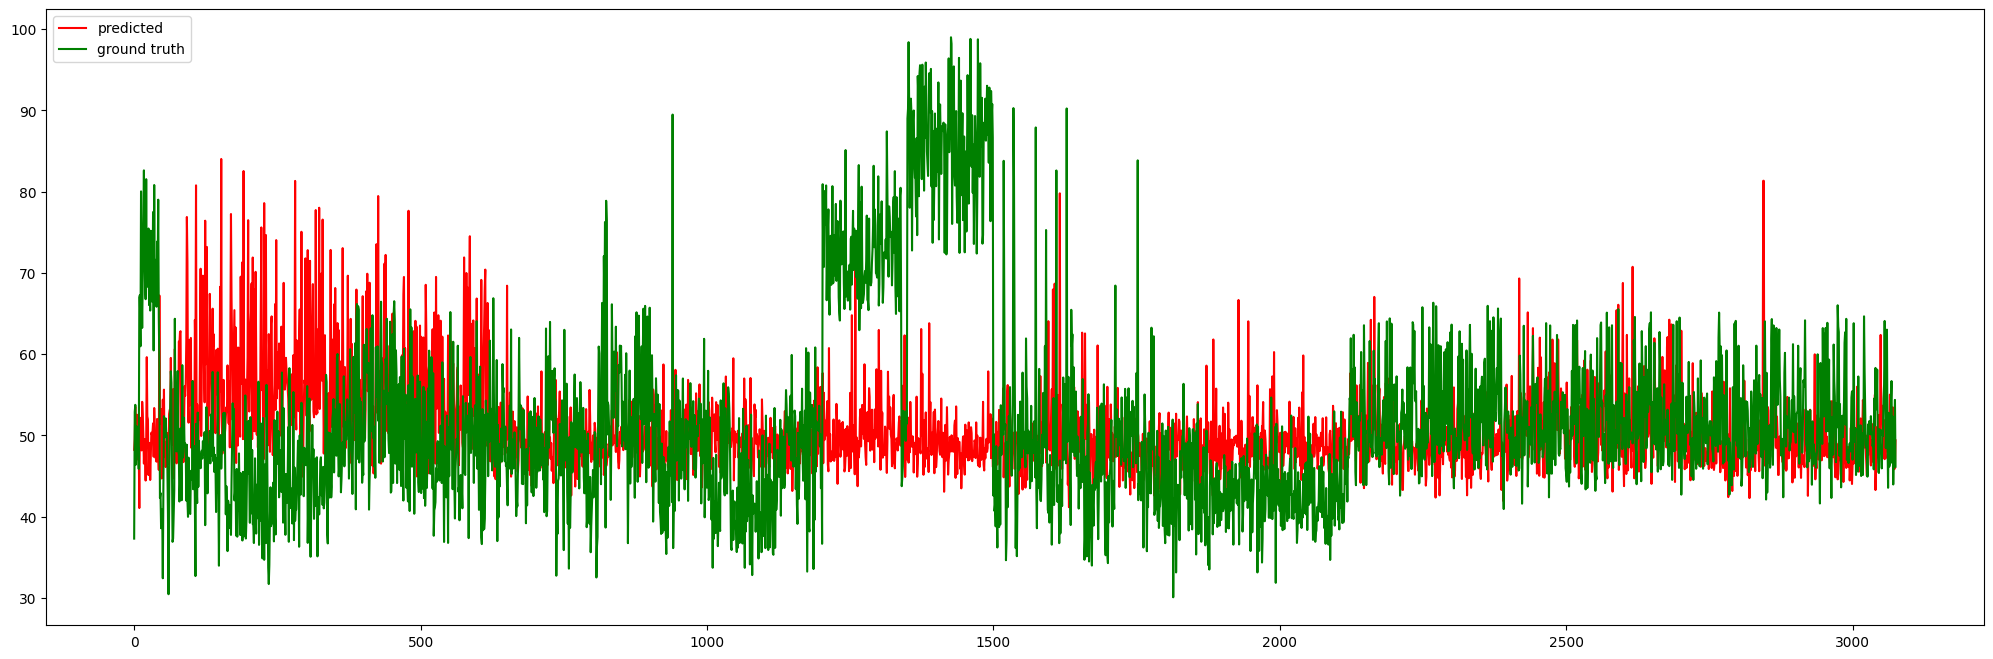

In [7]:
Trainer2 = Trainer()
FFNN_IF = regressionHead(train_IF_embedding.shape[1::] )
optIF = torch.optim.Adam(FFNN_IF.parameters(), lr=1e-4)
lossIF= torch.nn.MSELoss()
epochs = 200

generating_results_approaches(FFNN_IF, Trainer2, train_loaderIF, val_loaderIF, test_loaderIF,lossIF, optIF, epochs, device)

### Combining Raw ESM2 and Inverse Folding Embeddings

epoch: 1 loss: 901.097 val loss: 1157.556


epoch: 2 loss: 998.755 val loss: 542.937


epoch: 3 loss: 183.726 val loss: 257.282


epoch: 4 loss: 63.518 val loss: 150.567


epoch: 5 loss: 7.419 val loss: 120.761


epoch: 6 loss: 7.912 val loss: 114.419


epoch: 7 loss: 8.719 val loss: 113.678


epoch: 8 loss: 61.622 val loss: 113.995


epoch: 9 loss: 23.866 val loss: 114.140


epoch: 10 loss: 29.633 val loss: 113.532


epoch: 11 loss: 148.161 val loss: 113.701


epoch: 12 loss: 17.311 val loss: 113.642


epoch: 13 loss: 18.873 val loss: 113.838


epoch: 14 loss: 0.194 val loss: 113.486


epoch: 15 loss: 0.275 val loss: 84.669


epoch: 16 loss: 216.661 val loss: 66.102


epoch: 17 loss: 79.449 val loss: 56.699


epoch: 18 loss: 411.961 val loss: 52.143


epoch: 19 loss: 17.334 val loss: 49.874


epoch: 20 loss: 24.286 val loss: 48.301


epoch: 21 loss: 5.551 val loss: 47.097


epoch: 22 loss: 124.583 val loss: 46.830


epoch: 23 loss: 11.407 val loss: 47.677


epoch: 24 loss: 13.094 val loss: 46.316


epoch: 25 loss: 0.731 val loss: 46.382


epoch: 26 loss: 0.308 val loss: 45.827


epoch: 27 loss: 29.761 val loss: 45.581


epoch: 28 loss: 84.206 val loss: 45.542


epoch: 29 loss: 4.993 val loss: 45.388


epoch: 30 loss: 11.311 val loss: 45.750


epoch: 31 loss: 50.430 val loss: 44.766


epoch: 32 loss: 16.887 val loss: 44.962


epoch: 33 loss: 141.241 val loss: 44.702


epoch: 34 loss: 7.184 val loss: 44.933


epoch: 35 loss: 4.704 val loss: 44.283


epoch: 36 loss: 0.690 val loss: 44.750


epoch: 37 loss: 21.227 val loss: 44.936


epoch: 38 loss: 20.983 val loss: 44.861


epoch: 39 loss: 16.386 val loss: 43.699


epoch: 40 loss: 0.002 val loss: 44.394


epoch: 41 loss: 2.272 val loss: 43.680


epoch: 42 loss: 33.623 val loss: 43.736


epoch: 43 loss: 0.392 val loss: 43.435


epoch: 44 loss: 58.039 val loss: 44.096


epoch: 45 loss: 2.700 val loss: 43.523


epoch: 46 loss: 31.526 val loss: 43.007


epoch: 47 loss: 10.919 val loss: 43.378


epoch: 48 loss: 4.771 val loss: 43.293


epoch: 49 loss: 3.775 val loss: 43.719


epoch: 50 loss: 20.794 val loss: 42.741


epoch: 51 loss: 10.800 val loss: 42.899


epoch: 52 loss: 26.408 val loss: 42.678


epoch: 53 loss: 5.499 val loss: 42.549


epoch: 54 loss: 3.033 val loss: 42.702


epoch: 55 loss: 6.136 val loss: 42.758


epoch: 56 loss: 11.480 val loss: 42.356


epoch: 57 loss: 19.139 val loss: 42.382


epoch: 58 loss: 0.096 val loss: 42.092


epoch: 59 loss: 112.399 val loss: 42.810


epoch: 60 loss: 46.916 val loss: 42.366


epoch: 61 loss: 0.028 val loss: 42.041


epoch: 62 loss: 0.279 val loss: 42.231


epoch: 63 loss: 70.233 val loss: 42.371


epoch: 64 loss: 14.920 val loss: 42.031


epoch: 65 loss: 36.310 val loss: 42.166


epoch: 66 loss: 8.170 val loss: 42.718


epoch: 67 loss: 12.175 val loss: 42.513


epoch: 68 loss: 12.341 val loss: 42.256


epoch: 69 loss: 22.624 val loss: 43.026


epoch: 70 loss: 89.793 val loss: 42.472


epoch: 71 loss: 329.634 val loss: 41.881


epoch: 72 loss: 32.743 val loss: 43.205


epoch: 73 loss: 0.976 val loss: 42.604


epoch: 74 loss: 22.131 val loss: 42.305


epoch: 75 loss: 35.968 val loss: 45.479


epoch: 76 loss: 31.425 val loss: 42.089


epoch: 77 loss: 21.774 val loss: 42.436


epoch: 78 loss: 5.178 val loss: 42.136


epoch: 79 loss: 1.728 val loss: 42.044


epoch: 80 loss: 0.501 val loss: 42.536


epoch: 81 loss: 47.635 val loss: 42.121


epoch: 82 loss: 97.708 val loss: 43.025


epoch: 83 loss: 5.390 val loss: 41.981


epoch: 84 loss: 61.697 val loss: 42.430


epoch: 85 loss: 197.101 val loss: 42.238


epoch: 86 loss: 1.624 val loss: 43.239


epoch: 87 loss: 243.399 val loss: 42.510


epoch: 88 loss: 67.398 val loss: 42.511


epoch: 89 loss: 0.697 val loss: 42.314


epoch: 90 loss: 47.057 val loss: 42.551


epoch: 91 loss: 0.025 val loss: 42.670


epoch: 92 loss: 0.146 val loss: 42.296


epoch: 93 loss: 52.387 val loss: 42.465


epoch: 94 loss: 0.670 val loss: 43.897


epoch: 95 loss: 1.129 val loss: 43.147


epoch: 96 loss: 38.859 val loss: 42.431


epoch: 97 loss: 2.230 val loss: 42.405


epoch: 98 loss: 13.271 val loss: 42.368


epoch: 99 loss: 87.791 val loss: 42.966


epoch: 100 loss: 3.846 val loss: 43.494


epoch: 101 loss: 15.691 val loss: 42.832


epoch: 102 loss: 54.464 val loss: 42.420


epoch: 103 loss: 70.467 val loss: 44.394


epoch: 104 loss: 1.752 val loss: 43.126


epoch: 105 loss: 18.051 val loss: 43.836


epoch: 106 loss: 31.239 val loss: 42.955


epoch: 107 loss: 2.723 val loss: 42.613


epoch: 108 loss: 2.050 val loss: 43.321


epoch: 109 loss: 7.221 val loss: 42.713


epoch: 110 loss: 3.553 val loss: 42.598


epoch: 111 loss: 7.684 val loss: 43.823


epoch: 112 loss: 8.541 val loss: 42.888


epoch: 113 loss: 1.545 val loss: 42.831


epoch: 114 loss: 0.579 val loss: 42.788


epoch: 115 loss: 34.700 val loss: 43.755


epoch: 116 loss: 7.158 val loss: 43.092


epoch: 117 loss: 33.133 val loss: 44.794


epoch: 118 loss: 0.396 val loss: 43.503


epoch: 119 loss: 9.748 val loss: 43.042


epoch: 120 loss: 1.003 val loss: 42.956


epoch: 121 loss: 82.368 val loss: 43.191


epoch: 122 loss: 3.886 val loss: 43.095


epoch: 123 loss: 61.002 val loss: 44.113


epoch: 124 loss: 1.179 val loss: 43.165


epoch: 125 loss: 0.911 val loss: 43.410


epoch: 126 loss: 1.784 val loss: 43.367


epoch: 127 loss: 12.612 val loss: 43.259


epoch: 128 loss: 1.981 val loss: 43.646


epoch: 129 loss: 8.839 val loss: 43.304


epoch: 130 loss: 3.011 val loss: 43.329


epoch: 131 loss: 7.877 val loss: 44.542


epoch: 132 loss: 12.035 val loss: 43.474


epoch: 133 loss: 360.688 val loss: 43.779


epoch: 134 loss: 28.365 val loss: 44.325


epoch: 135 loss: 0.440 val loss: 43.575


epoch: 136 loss: 32.394 val loss: 44.034


epoch: 137 loss: 0.726 val loss: 43.739


epoch: 138 loss: 6.274 val loss: 43.572


epoch: 139 loss: 3.367 val loss: 44.130


epoch: 140 loss: 102.170 val loss: 45.715


epoch: 141 loss: 38.019 val loss: 43.610


epoch: 142 loss: 15.309 val loss: 44.002


epoch: 143 loss: 37.317 val loss: 43.816


epoch: 144 loss: 0.030 val loss: 43.590


epoch: 145 loss: 0.403 val loss: 43.533


epoch: 146 loss: 89.418 val loss: 43.838


epoch: 147 loss: 67.895 val loss: 43.754


epoch: 148 loss: 4.032 val loss: 43.666


epoch: 149 loss: 49.082 val loss: 43.725


epoch: 150 loss: 0.621 val loss: 43.808


epoch: 151 loss: 5.667 val loss: 43.730


epoch: 152 loss: 3.158 val loss: 43.544


epoch: 153 loss: 1.256 val loss: 44.110


epoch: 154 loss: 40.614 val loss: 44.173


epoch: 155 loss: 3.750 val loss: 43.657


epoch: 156 loss: 0.038 val loss: 43.864


epoch: 157 loss: 0.649 val loss: 43.849


epoch: 158 loss: 3.379 val loss: 44.707


epoch: 159 loss: 85.031 val loss: 44.215


epoch: 160 loss: 0.108 val loss: 44.001


epoch: 161 loss: 12.963 val loss: 46.024


epoch: 162 loss: 26.708 val loss: 44.961


epoch: 163 loss: 1.256 val loss: 43.982


epoch: 164 loss: 41.837 val loss: 44.005


epoch: 165 loss: 3.898 val loss: 43.856


epoch: 166 loss: 0.000 val loss: 43.893


epoch: 167 loss: 19.512 val loss: 43.809


epoch: 168 loss: 3.444 val loss: 44.705


epoch: 169 loss: 0.642 val loss: 44.120


epoch: 170 loss: 18.523 val loss: 44.128


epoch: 171 loss: 31.533 val loss: 44.045


epoch: 172 loss: 13.249 val loss: 44.455


epoch: 173 loss: 22.278 val loss: 44.147


epoch: 174 loss: 0.071 val loss: 46.330


epoch: 175 loss: 1.711 val loss: 44.862


epoch: 176 loss: 0.918 val loss: 44.390


epoch: 177 loss: 8.892 val loss: 44.608


epoch: 178 loss: 2.604 val loss: 44.442


epoch: 179 loss: 6.831 val loss: 44.068


epoch: 180 loss: 0.024 val loss: 44.072


epoch: 181 loss: 9.443 val loss: 44.189


epoch: 182 loss: 23.359 val loss: 44.398


epoch: 183 loss: 0.782 val loss: 45.681


epoch: 184 loss: 1.111 val loss: 45.007


epoch: 185 loss: 75.196 val loss: 44.650


epoch: 186 loss: 0.053 val loss: 44.410


epoch: 187 loss: 0.176 val loss: 44.518


epoch: 188 loss: 17.481 val loss: 44.709


epoch: 189 loss: 29.511 val loss: 45.125


epoch: 190 loss: 4.790 val loss: 44.409


epoch: 191 loss: 0.221 val loss: 44.948


epoch: 192 loss: 4.535 val loss: 44.661


epoch: 193 loss: 10.388 val loss: 45.639


epoch: 194 loss: 4.089 val loss: 44.535


epoch: 195 loss: 12.773 val loss: 46.209


epoch: 196 loss: 13.036 val loss: 46.249


epoch: 197 loss: 0.726 val loss: 44.623


epoch: 198 loss: 24.792 val loss: 44.712


epoch: 199 loss: 54.802 val loss: 45.721


epoch: 200 loss: 0.230 val loss: 44.966
MSE: tensor(45.7692, device='cuda:0', grad_fn=<MseLossBackward0>)
RMSE: tensor(6.7653, device='cuda:0', grad_fn=<SqrtBackward0>)
MAE: tensor(5.0132, device='cuda:0', grad_fn=<MeanBackward0>)


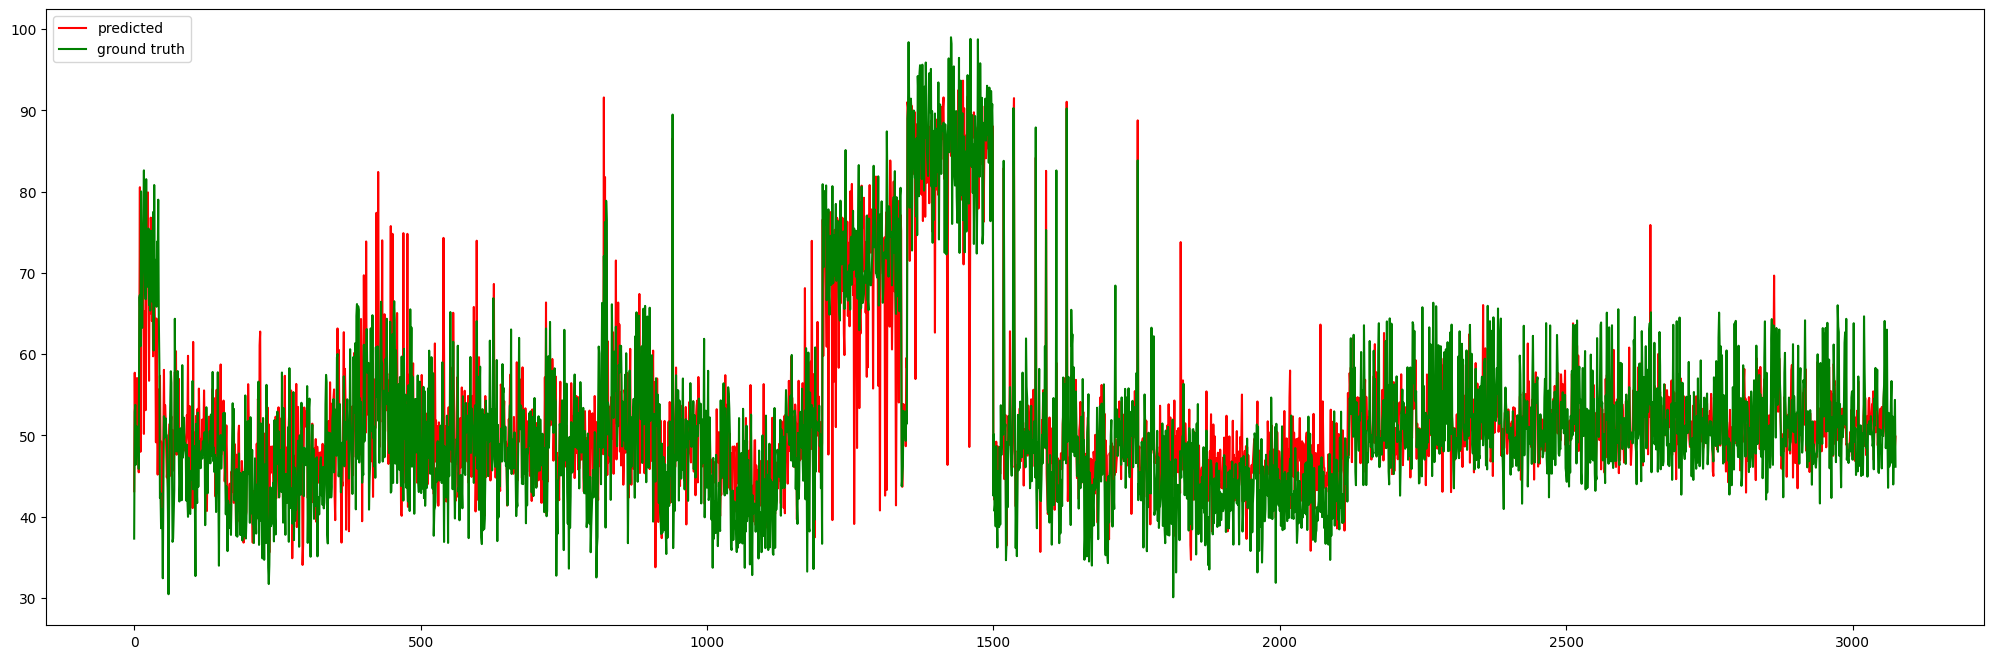

In [8]:
Trainer3 = Trainer()
FFNN_Mixed = regressionHead(train_IF_embedding.size(1) + train_embeddings.size(1))
optMixed = torch.optim.Adam(FFNN_Mixed.parameters(), lr=1e-4)
lossMixed= torch.nn.MSELoss()
epochs = 200

generating_results_approaches(FFNN_Mixed, Trainer3, train_loaderMixed, val_loaderMixed, test_loaderMixed,lossMixed, optMixed, epochs, device)